In [18]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.preprocessing import MinMaxScaler

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from keras.optimizers import SGD

In [4]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [5]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing

In [8]:
x_train = train_data.drop(['label'], axis=1)
y_train = train_data['label']
x_test = test_data
scaler = MinMaxScaler()

In [9]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Good news - all classes have roughly the same number of samples so we don't have to handle class imbalance.

In [10]:
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=scaler.feature_names_in_)
x_test = pd.DataFrame(scaler.transform(x_test), columns=scaler.feature_names_in_)

x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)
y_train = to_categorical(y_train, num_classes=10)

# Model

In [11]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), kernel_initializer='he_uniform', padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='he_uniform', padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_uniform', padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
model.add(BatchNormalization())


model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

Before fitting the model on train data, compile it with an appropriate optimizer, loss function and metric. I will use a custom SGD optimizer with momentum 0.9 but you can also use a simple adam optimizer with `optimizer='adam'`. Categorical Crossentropy is a good loss function for this problem since it's a multi class classification. Accuracy is a suitable metric since all classes have roughly the same number of samples.

In [12]:
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9,), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_split=0.1, batch_size=50, epochs=50, verbose=2)

predictions = model.predict(x_test)
n_predictions = np.argmax(predictions, axis=1)

Epoch 1/50
756/756 - 17s - loss: 0.1006 - accuracy: 0.9694 - val_loss: 0.0514 - val_accuracy: 0.9800 - 17s/epoch - 22ms/step
Epoch 2/50
756/756 - 4s - loss: 0.0309 - accuracy: 0.9911 - val_loss: 0.0336 - val_accuracy: 0.9890 - 4s/epoch - 6ms/step
Epoch 3/50
756/756 - 4s - loss: 0.0159 - accuracy: 0.9957 - val_loss: 0.0356 - val_accuracy: 0.9890 - 4s/epoch - 5ms/step
Epoch 4/50
756/756 - 4s - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0340 - val_accuracy: 0.9895 - 4s/epoch - 5ms/step
Epoch 5/50
756/756 - 4s - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0290 - val_accuracy: 0.9912 - 4s/epoch - 5ms/step
Epoch 6/50
756/756 - 4s - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0278 - val_accuracy: 0.9921 - 4s/epoch - 5ms/step
Epoch 7/50
756/756 - 4s - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0243 - val_accuracy: 0.9924 - 4s/epoch - 5ms/step
Epoch 8/50
756/756 - 4s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0260 - val_accuracy: 0.9924 - 4s/epoch - 5ms/step
Epoch 9/50
756/756 - 

# Submission

Observe the sample submission and submit your predictions in the same format.

In [13]:
pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [14]:
df = pd.DataFrame()
df['ImageId'] = range(1, 28001)
df['Label'] = n_predictions
df.to_csv('submission.csv', index=False)

In [16]:
testImgPred = [np.argmax(predictions[x]) for x in range(50)]

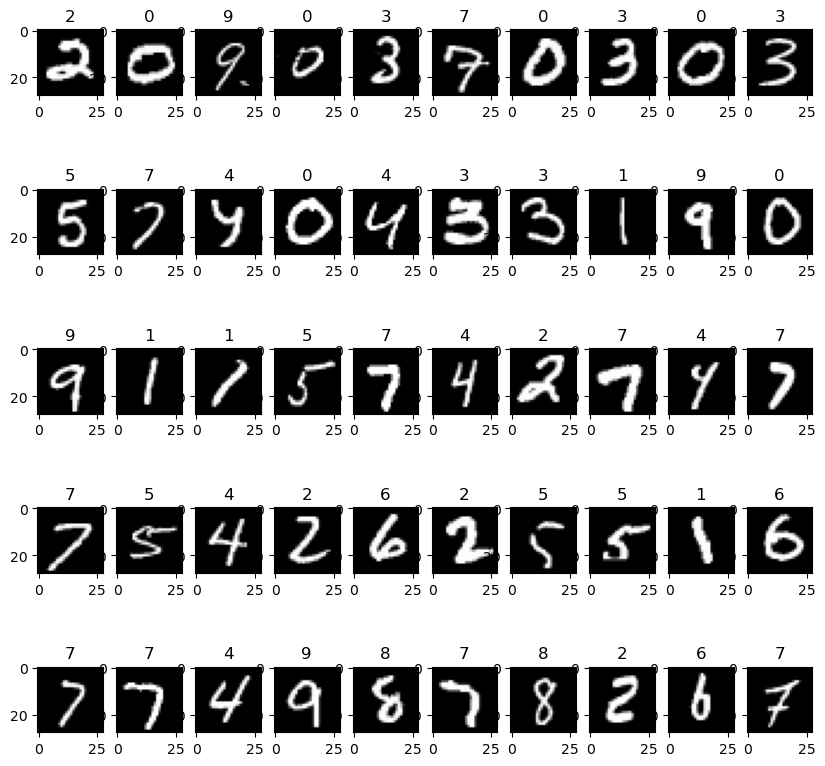

In [20]:
plt.figure(figsize=(10,10))

for i in range (50):
    plt.subplot(5, 10, i+1)
    img = np.reshape(x_test[i], (28, 28))
    plt.imshow(img, cmap='gray')
    plt.title(testImgPred[i])
plt.show()